# Notebook for developing the QC pipeline
## Setup
### User parameters

In [1]:
model_name = "qualityControlV1"

### Imports

In [2]:
import os, sys
# Move working directory to the root of the project
os.chdir("/home/ucloud/EUMothModel")
print("Working directory:", os.getcwd())

import utils.dataloader as dl
import utils.mount as m

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

Working directory: /home/ucloud/EUMothModel


### Cuda detection & Datatype selection

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)
dtype = torch.bfloat16

Device: cpu


### Mount

In [4]:
m.unmount()
# IF **NOT** MOUNTED
m.mount()

Remote directory is not mounted
Local directory does not exist
Mounting remote directory with command: rclone mount erda:/AMI_GBIF_Pretraining_Data/root erda-home --vfs-cache-mode full --vfs-read-chunk-size 1M --vfs-cache-max-age 10h --vfs-cache-max-size 500G --max-read-ahead 1M --dir-cache-time 15m --fast-list --transfers 10 --daemon
Mounted remote directory successfully


True

### Dataloader

In [5]:
weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
image_preprocessing = weights.transforms(antialias=True)
def denormalize(tensor, mean=image_preprocessing.mean, std=image_preprocessing.std):
    """Denormalize a tensor."""
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(torch.float32)
    std = torch.tensor(std).view(1, 3, 1, 1).to(torch.float32)
    return tensor.cpu().to(torch.float32) * std + mean

batch_size, numworkers, pin_memory = dl.config['batch_size'], dl.config['num_workers'], dl.config['pin_memory']

dataset = dl.PretrainingDataset(n_max=100, transform=image_preprocessing)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=numworkers, pin_memory=pin_memory)

### Model import
The model has been trained on a small hand-annotated dataset. Unfortunately this is currently a quite messy workflow, since it is done it Google Colab and not on uCloud, where the rest of the processing will be done. This will be fixed later and is an issue of asyncronous software and infrastructure development.

In [18]:
# model: efficientnet_v2_s
model = torchvision.models.efficientnet_v2_s(weights = weights).train(False).half()
num_features = [k for k in [j for j in [i for i in model.children()][0].children()][-1].children()][0].out_channels
num_classes = 3
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.BatchNorm1d(num_features),
    nn.Linear(num_features, 512),
    nn.BatchNorm1d(512),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(512, num_classes),
)
model.load_state_dict(torch.load("models/{model_name}.pt"))
model = model.to(device=device, dtype=dtype)
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

## Inference

In [19]:
class EmbedEfficientNet(nn.Module):
    def __init__(self, original_model):
        super(EmbedEfficientNet, self).__init__()

        children = list(original_model.children())

        # Extract all layers except the classifier
        self.features = nn.Sequential(*children)[:-1]

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        return x

embeddings_model = EmbedEfficientNet(model)

In [20]:
predictions, images, embeddings = [], [], []

# inference loop
with torch.no_grad():
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device=device, dtype=dtype)
        scores = model(inputs)
        embeddings.append(embeddings_model(inputs).float().cpu().numpy())
        preds = scores.float().exp()
        preds /= preds.sum(dim=1, keepdim=True)
        predictions.append(preds.cpu().numpy())
        images.append(denormalize(inputs).cpu().numpy())

predictions = np.concatenate(predictions)
images = np.concatenate(images)
embeddings = np.concatenate(embeddings)

  0%|          | 0/7 [00:00<?, ?it/s]

In [22]:
images[0].flatten()

array([0.63170314, 0.62723047, 0.62365234, ..., 0.3607363 , 0.3607363 ,
       0.35678124], dtype=float32)

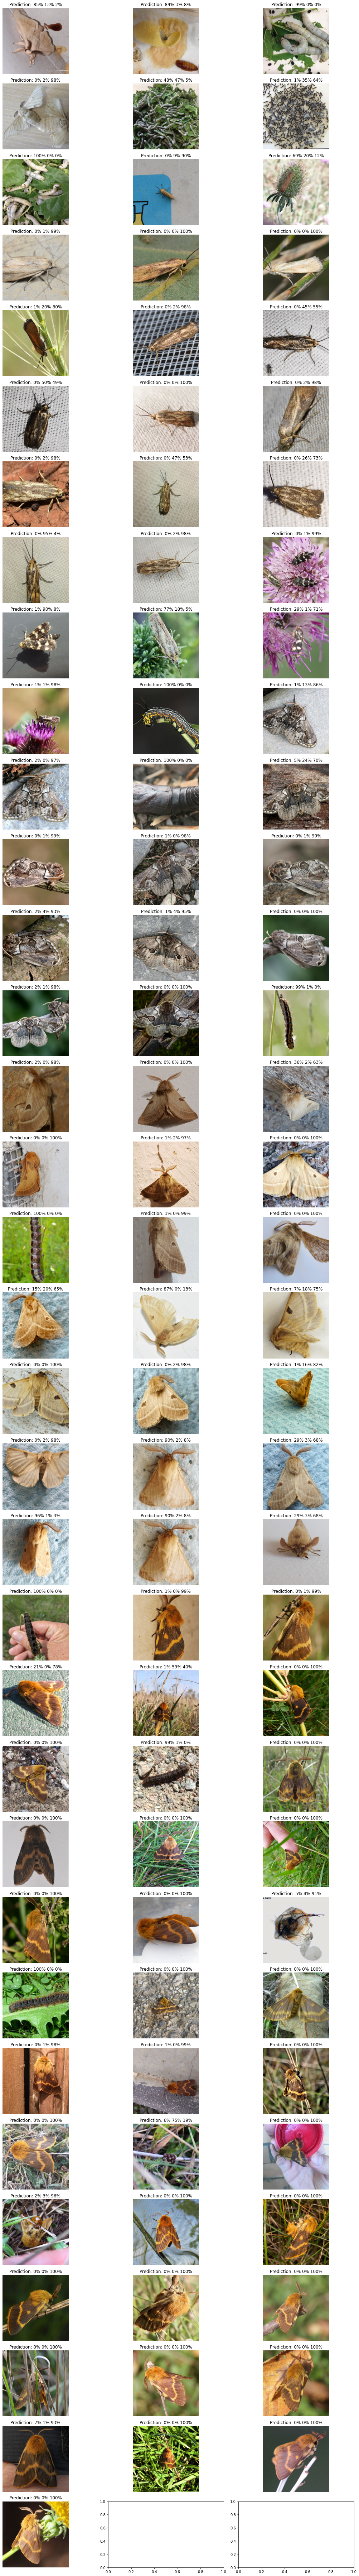

In [25]:
# Plot predictions 
fig, ax = plt.subplots(34, 3, figsize=(15, 100))

for i in range(100):
    this_row = images[i].transpose(1,2,0)
    # clamp
    this_row = np.clip(this_row, 0, 1)
    ax[i//3, i%3].imshow(this_row)
    ax[i//3, i%3].set_title(f"Prediction: {predictions[i][0]:.0%} {predictions[i][1]:.0%} {predictions[i][2]:.0%}")
    ax[i//3, i%3].axis('off')

plt.tight_layout()
plt.show()

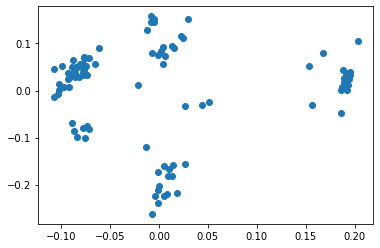

In [85]:
embeddings_normalized = torch.tensor(embeddings)
embeddings_normalized /= embeddings_normalized.norm(dim=1, keepdim=True)
plt.scatter(*torch.pca_lowrank(embeddings_normalized, q=2)[0].numpy().transpose())